# Analisis bivariado

En este jupiter veremos la relacion de nuestras variables tanto categoricas como numericas con 'get_account_?'

In [1]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu # Para pruebas estadísticas

df_bank_ready = pd.read_csv("ready_bank_prediction.csv")

Otra ves toco cambiar el tipo de day =) esto es algo que venimos arratrando desde el analisis univariado ya que pandas interpreta esta columna como numerica y en el contexto del problema que queremos resolver necesitamos que esta sea categorica

In [2]:
print(df_bank_ready["day"].dtype)
df_bank_ready["day"] = df_bank_ready["day"].astype("category")
print(df_bank_ready["day"].dtype)


int64
category


Cuando hacia la prueba chi cuadrada note la un problema que al parecer arrastre de los analisis anteriores y es que la columna 'hubo_contacto' valdra yes miestras que en esa misma fila el valor de 'pdays' no sea 0 y del valor de 'pdays' ser mayor que 0 'hubo_contacto' valdra yes

In [3]:
# Modificamos la columna 'hubo_contacto_?' según la condición de 'pdays_dias_transcurridos_log'
df_bank_ready.loc[df_bank_ready['pdays_dias_transcurridos_log'] == 0, 'hubo_contacto_?'] = 'no'

## Analisis bivariado con variables categoricas



In [ ]:
# Nos aseguramos que 'get_account_?' sea categórica (y si es binaria, es mejor que sea 0/1 para algunas visualizaciones/métodos)
# Para el análisis bivariado, 'yes'/'no' es visualmente claro, pero para el modelo la convertiríamos a 1/0.
# Aquí la mantendremos como categórica por ahora para los gráficos.
df_bank_ready['get_account_?'] = df_bank_ready['get_account_?'].astype('category')

# Identificar tipos de columnas para el análisis bivariado
categorical_cols = df_bank_ready.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_bank_ready.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Excluir la variable objetivo y la columna 'id' si existen de las listas de predictores
if 'get_account_?' in categorical_cols:
    categorical_cols.remove('get_account_?')
if 'id' in numerical_cols: # Si tienes una columna 'id' que no es un predictor
    numerical_cols.remove('id')
if 'day' in numerical_cols:
    # 'day' es numérica pero a menudo se trata como categórica si su valor no es lineal.
    # Para el análisis bivariado, podemos analizarla en ambas formas o decidir.
    # Aquí la movemos a categóricas para probar.
    categorical_cols.append('day')
    numerical_cols.remove('day')
    df_bank_ready['day'] = df_bank_ready['day'].astype('category')


print("--- Columnas Categóricas para Análisis Bivariado ---")
print(categorical_cols)
print("\n--- Columnas Numéricas para Análisis Bivariado ---")
print(numerical_cols)

target_variable = 'get_account_?'

--- Columnas Categóricas para Análisis Bivariado ---
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'hubo_contacto_?']

--- Columnas Numéricas para Análisis Bivariado ---
['age', 'balance_log', 'campaign_log', 'pdays_dias_transcurridos_log', 'previous_log']


In [5]:
# --- Función para calcular Cramer's V ---
def calculate_cramers_v(chi2_stat, n, df):
    """
    Calcula el estadístico Cramer's V.
    chi2_stat: Estadístico Chi-cuadrado
    n: Número total de observaciones
    df: Grados de libertad (min(filas-1, columnas-1))
    """
    if n == 0 or df == 0:
        return 0.0 # Evitar división por cero
    phi2 = chi2_stat / n
    v = np.sqrt(phi2 / df)
    return v


# 1. Análisis Bivariado Consolidado: Variables Categóricas vs. 'get_account_?' (Tabla Ajustada)
------------------------------------------------------------------------------------------------



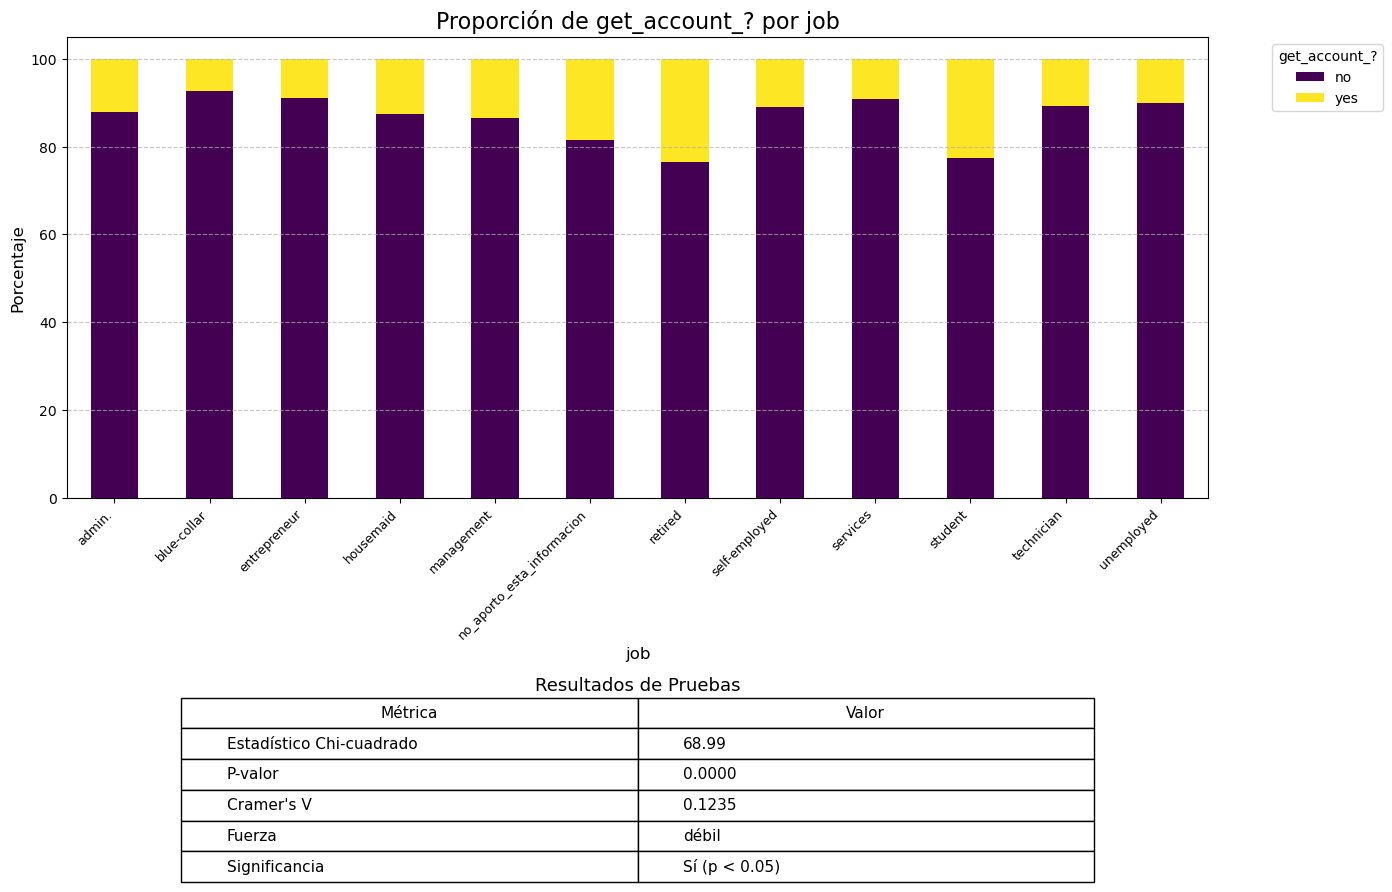

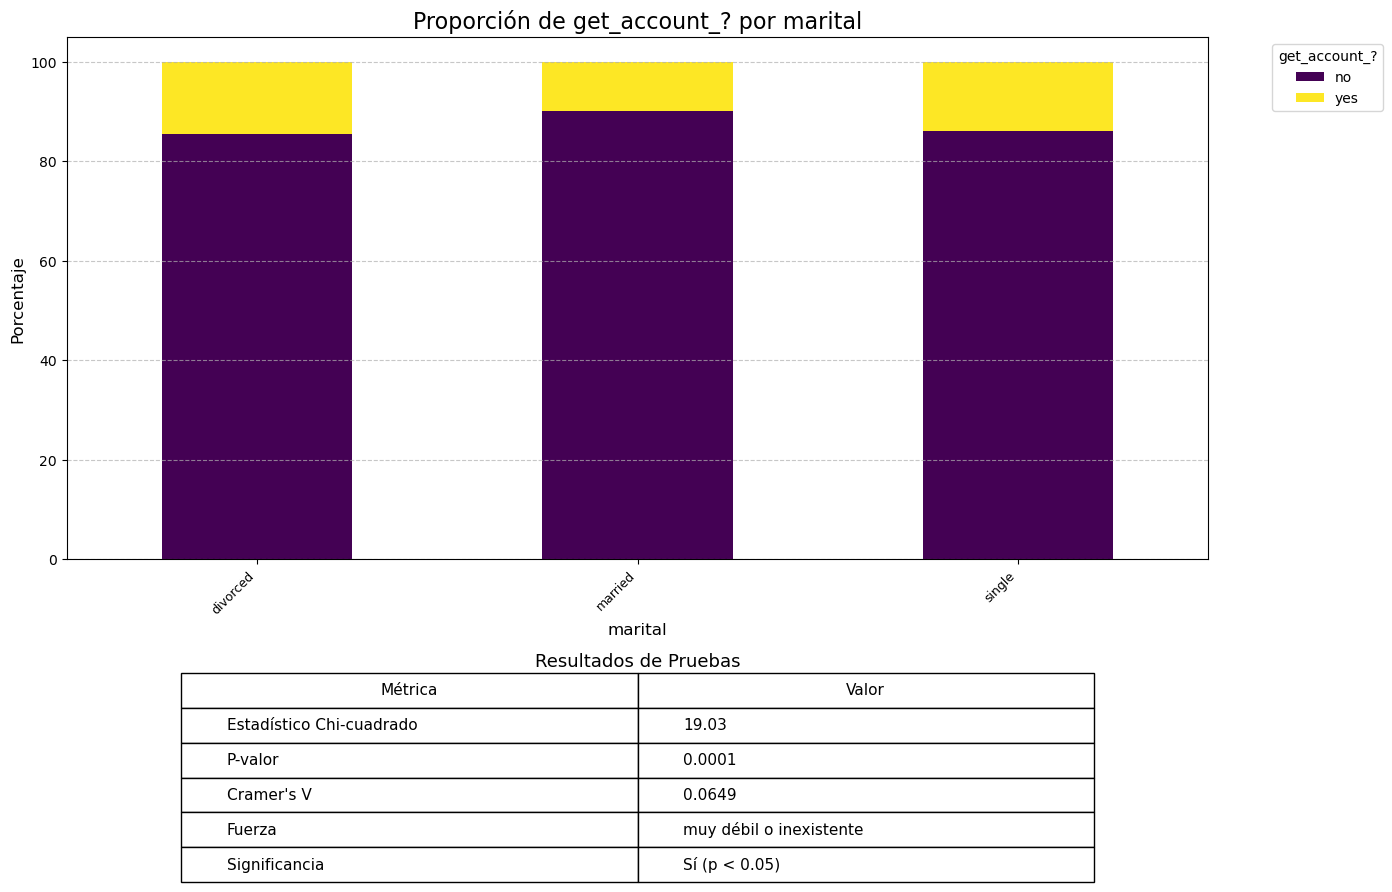

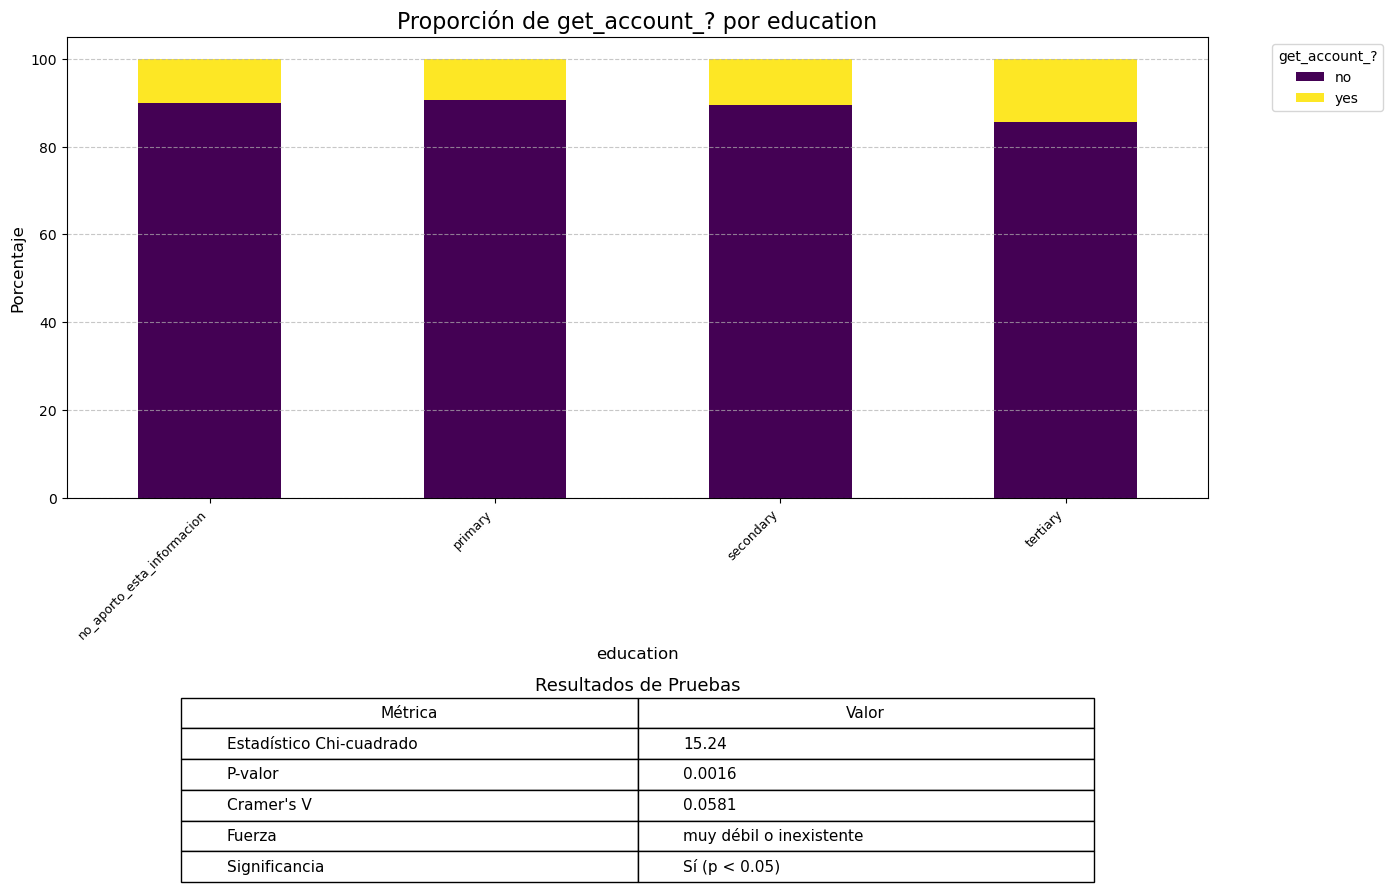

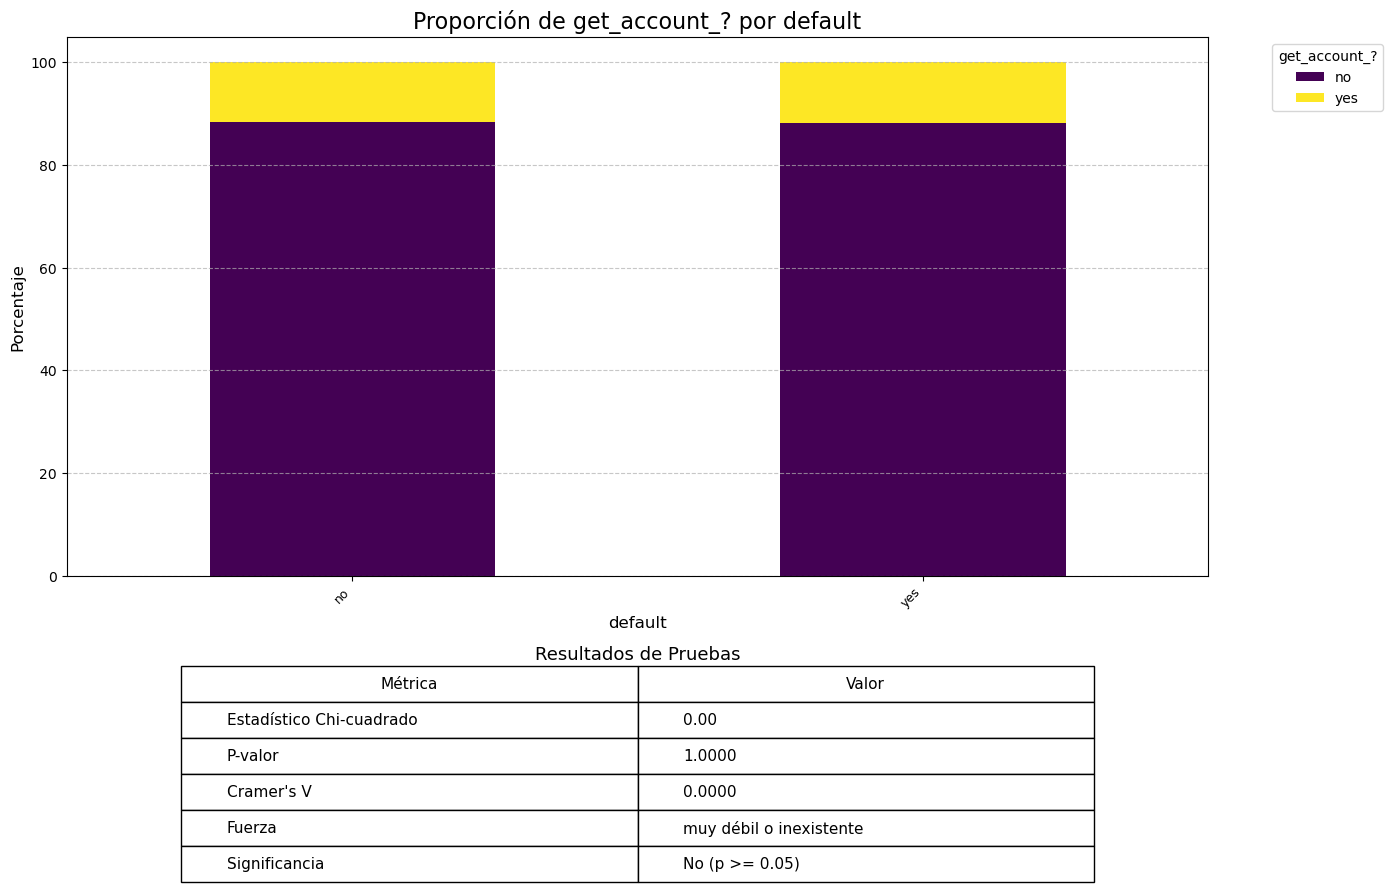

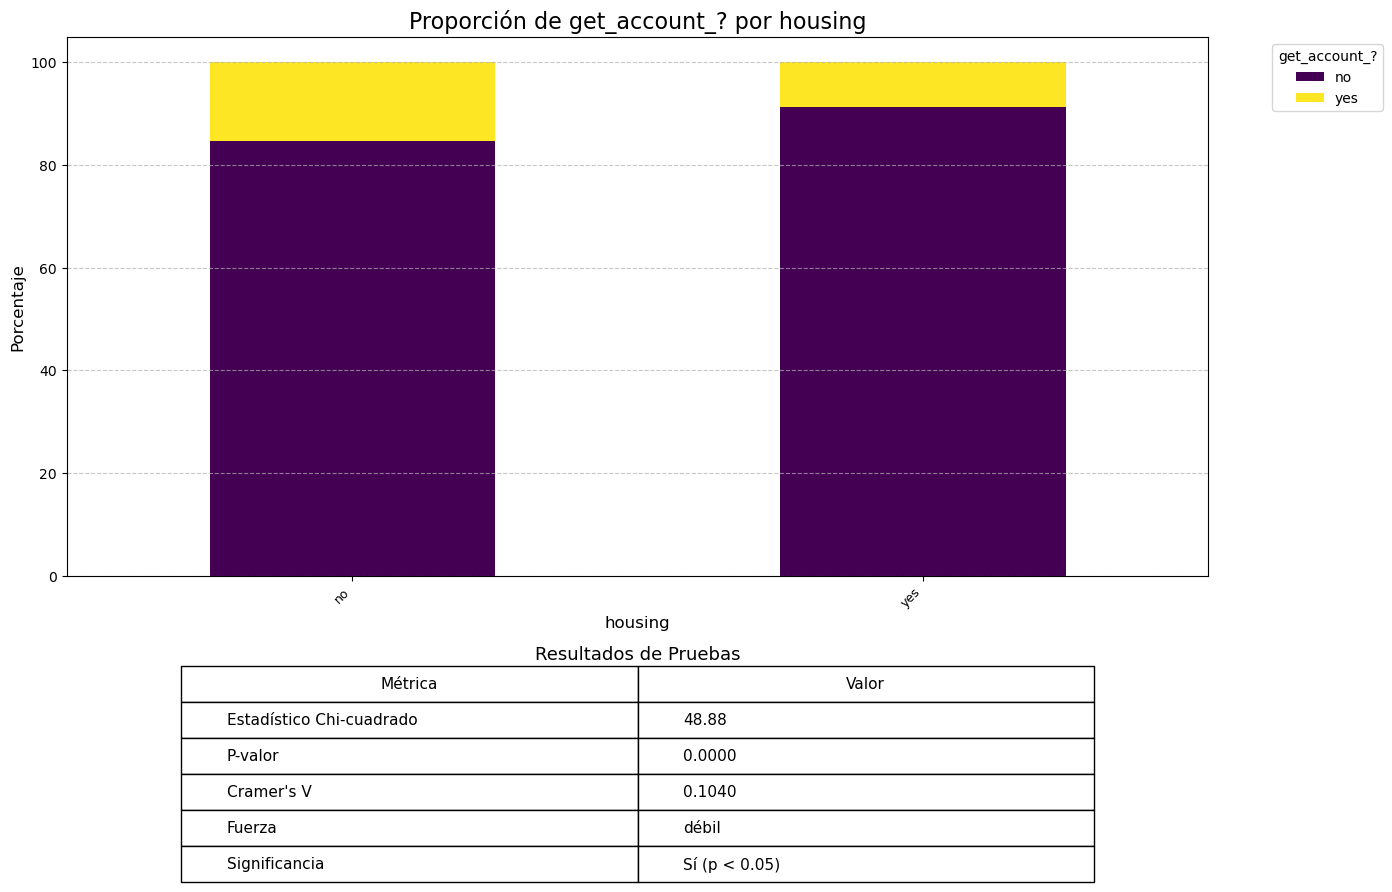

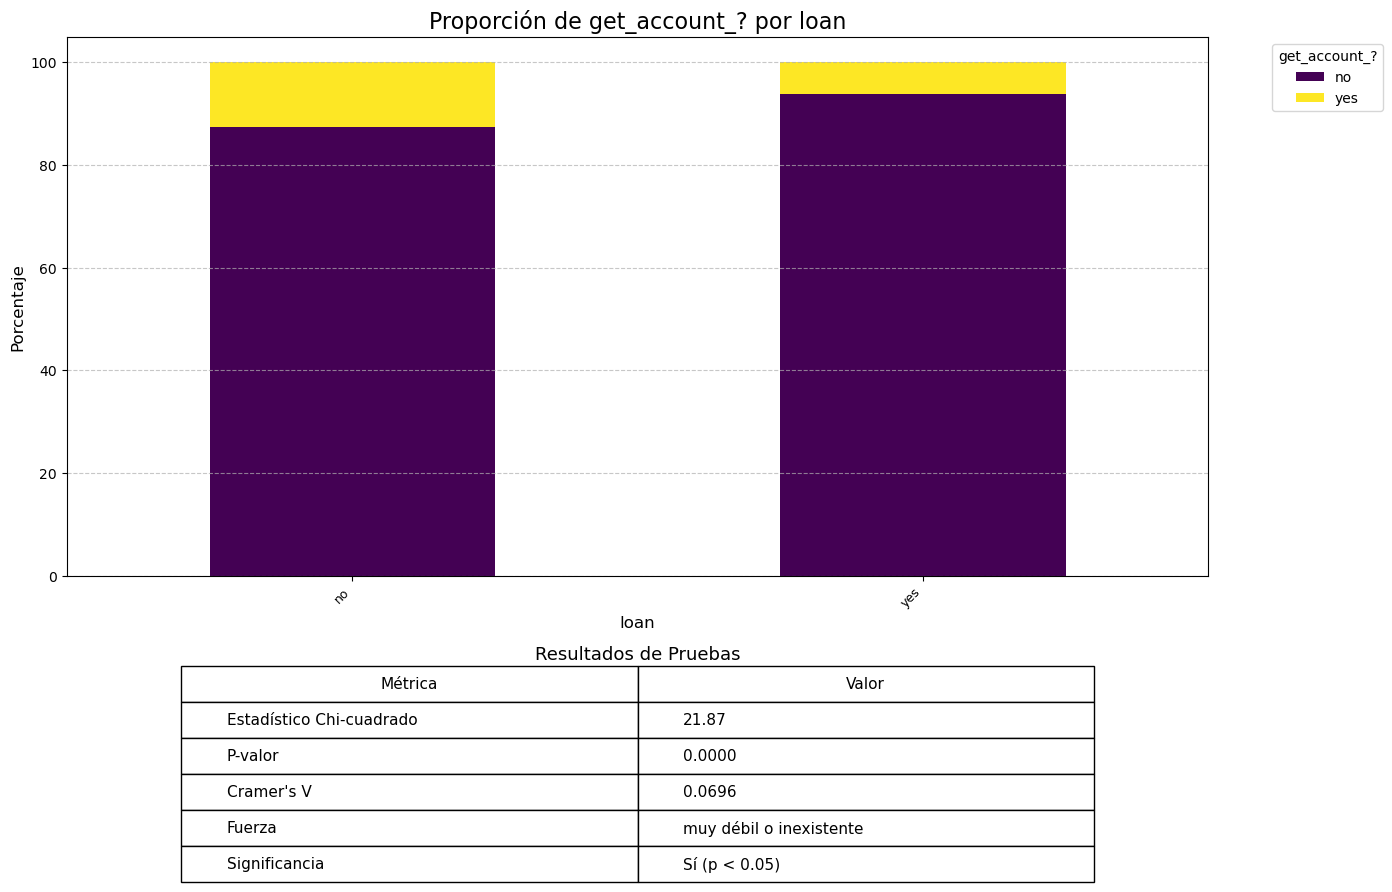

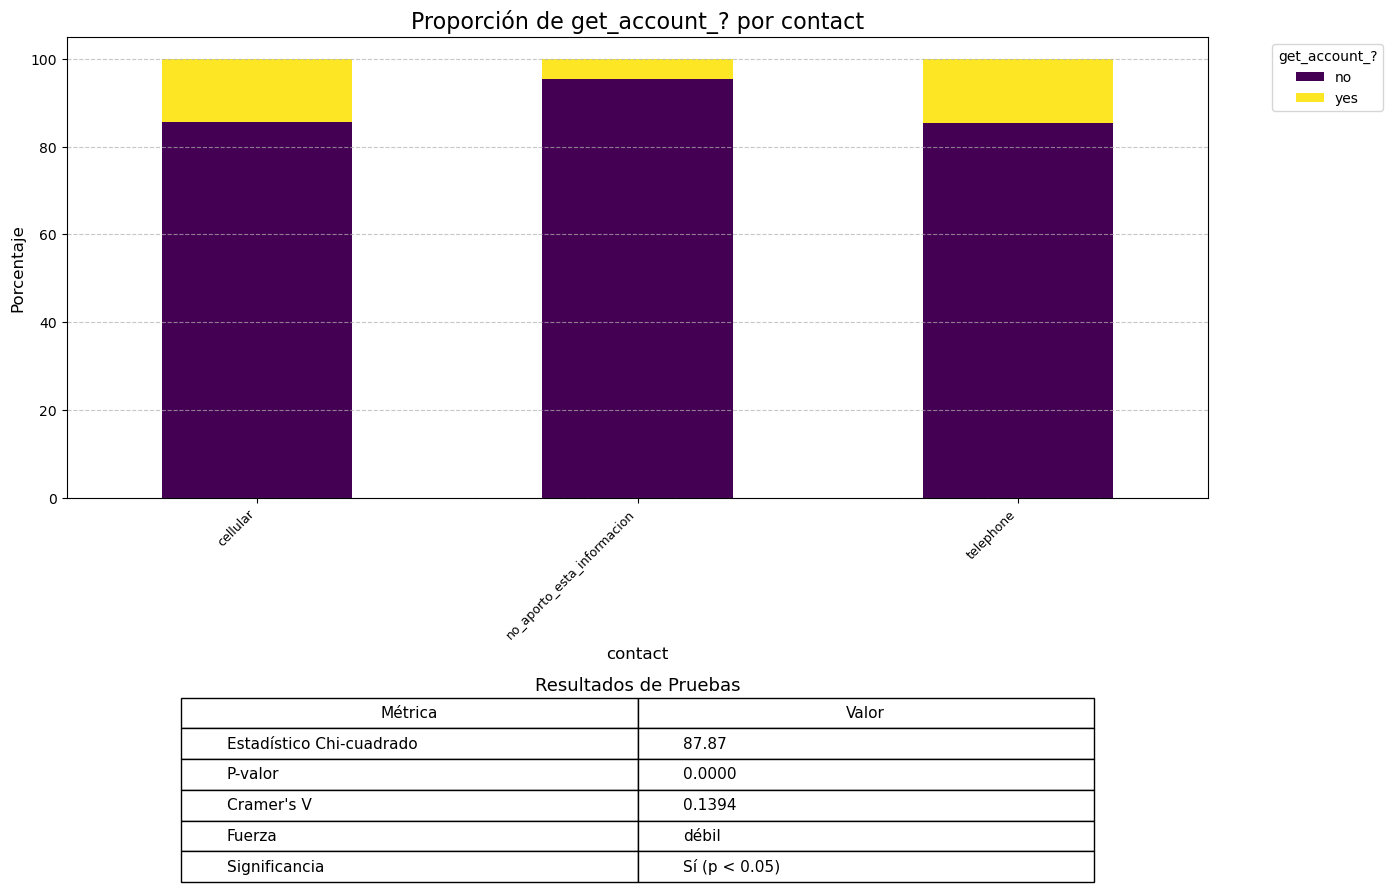

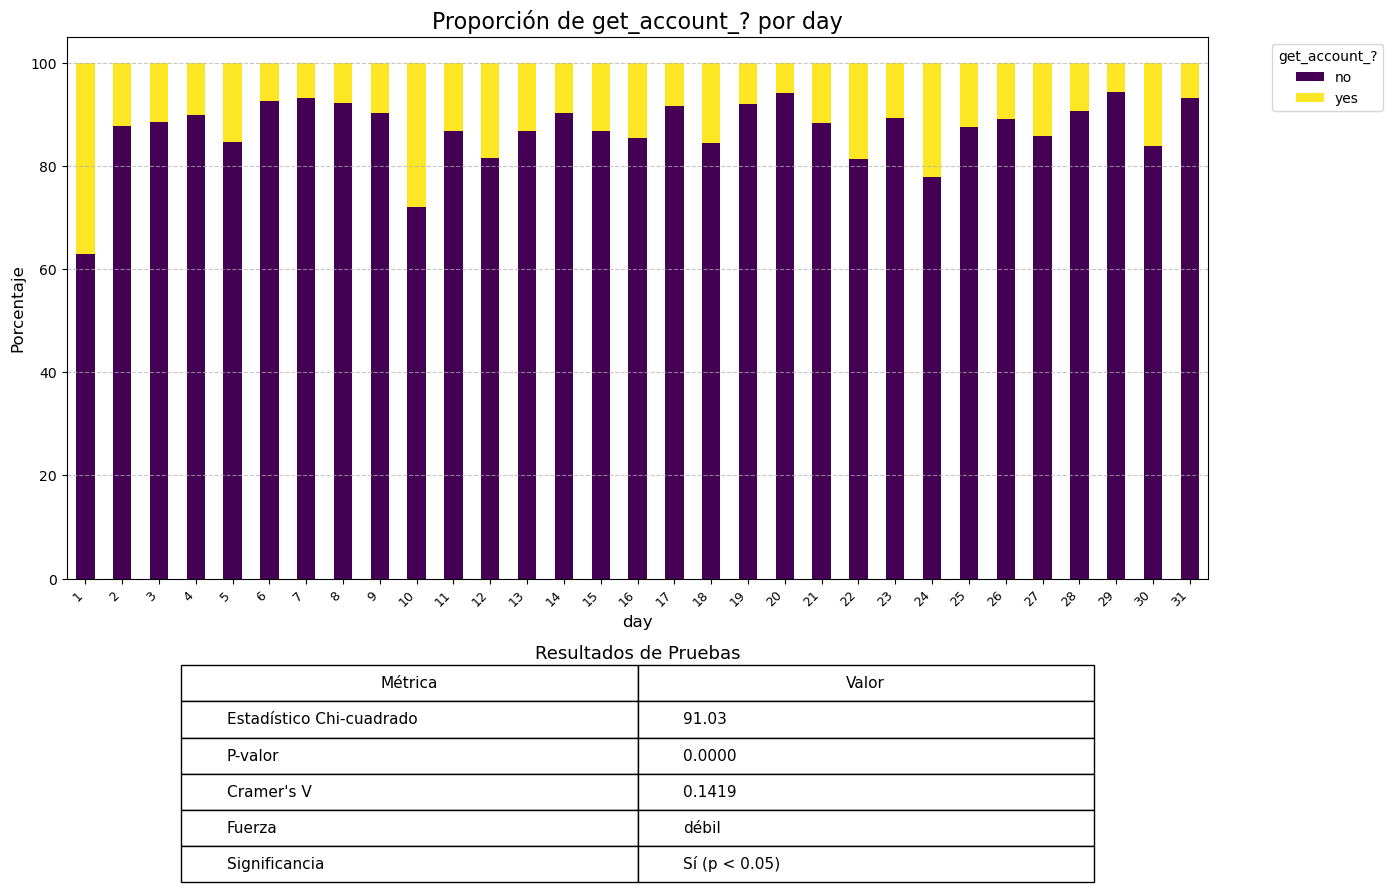

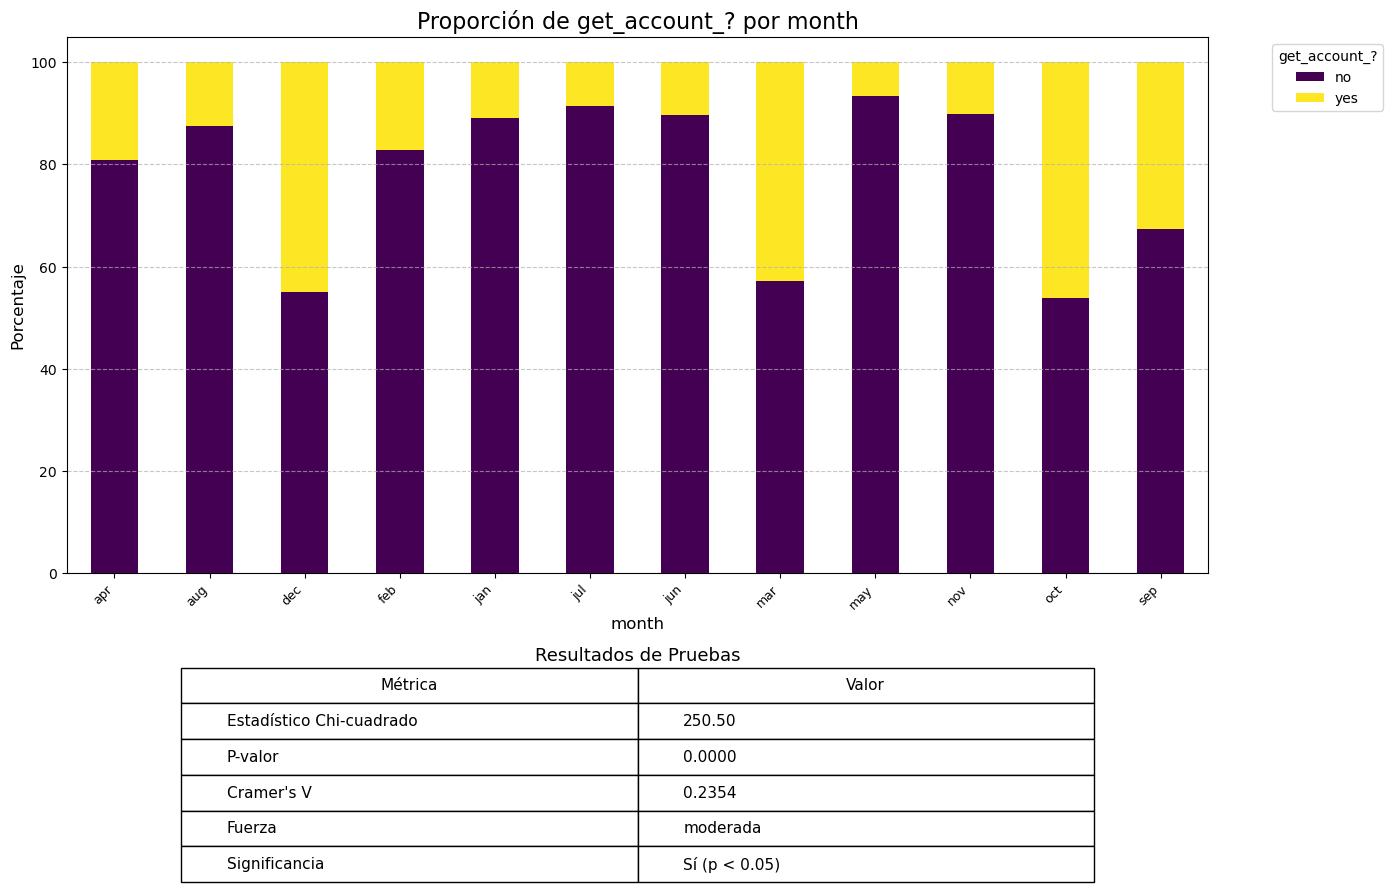

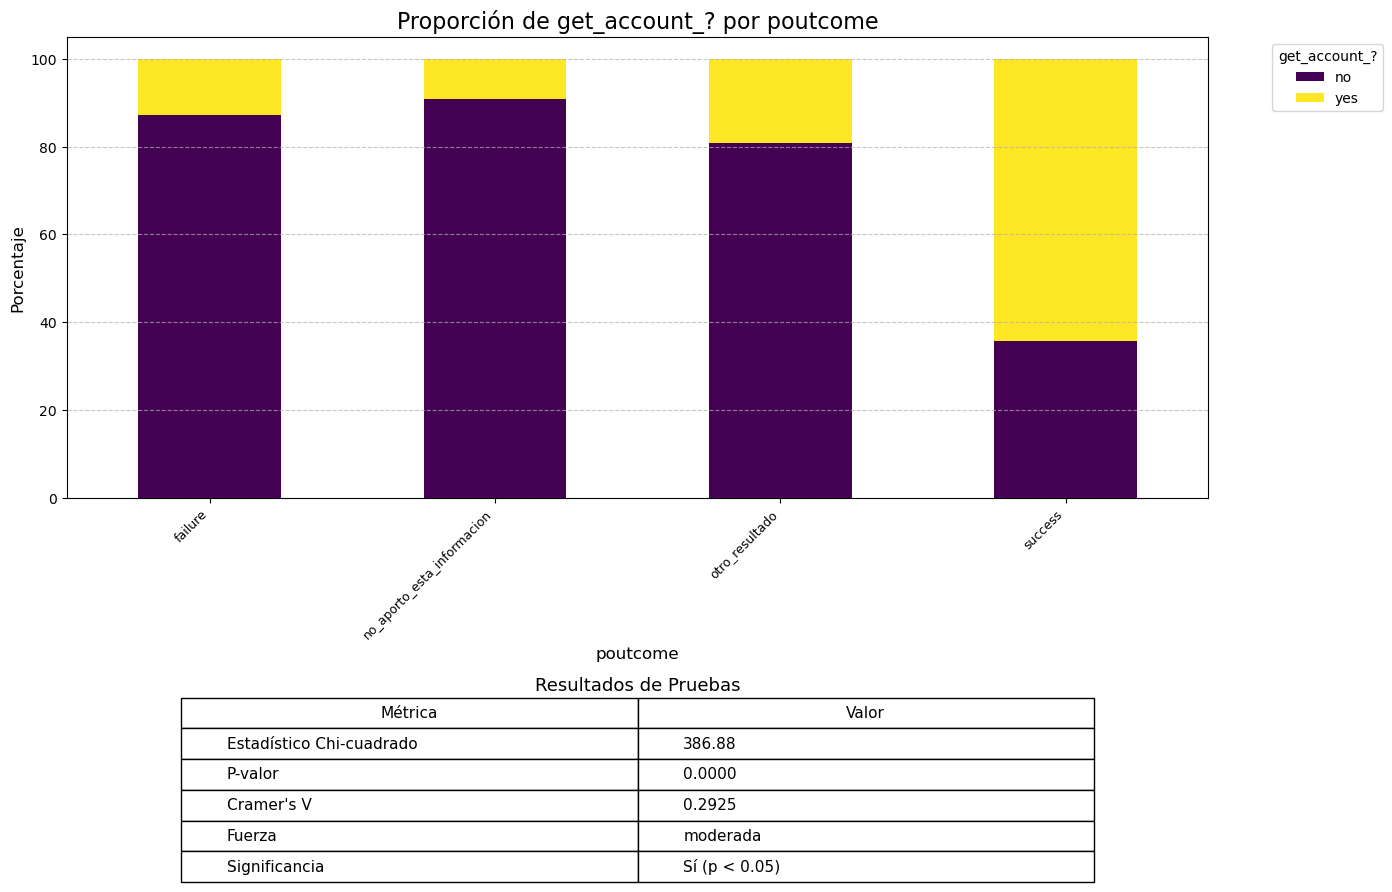

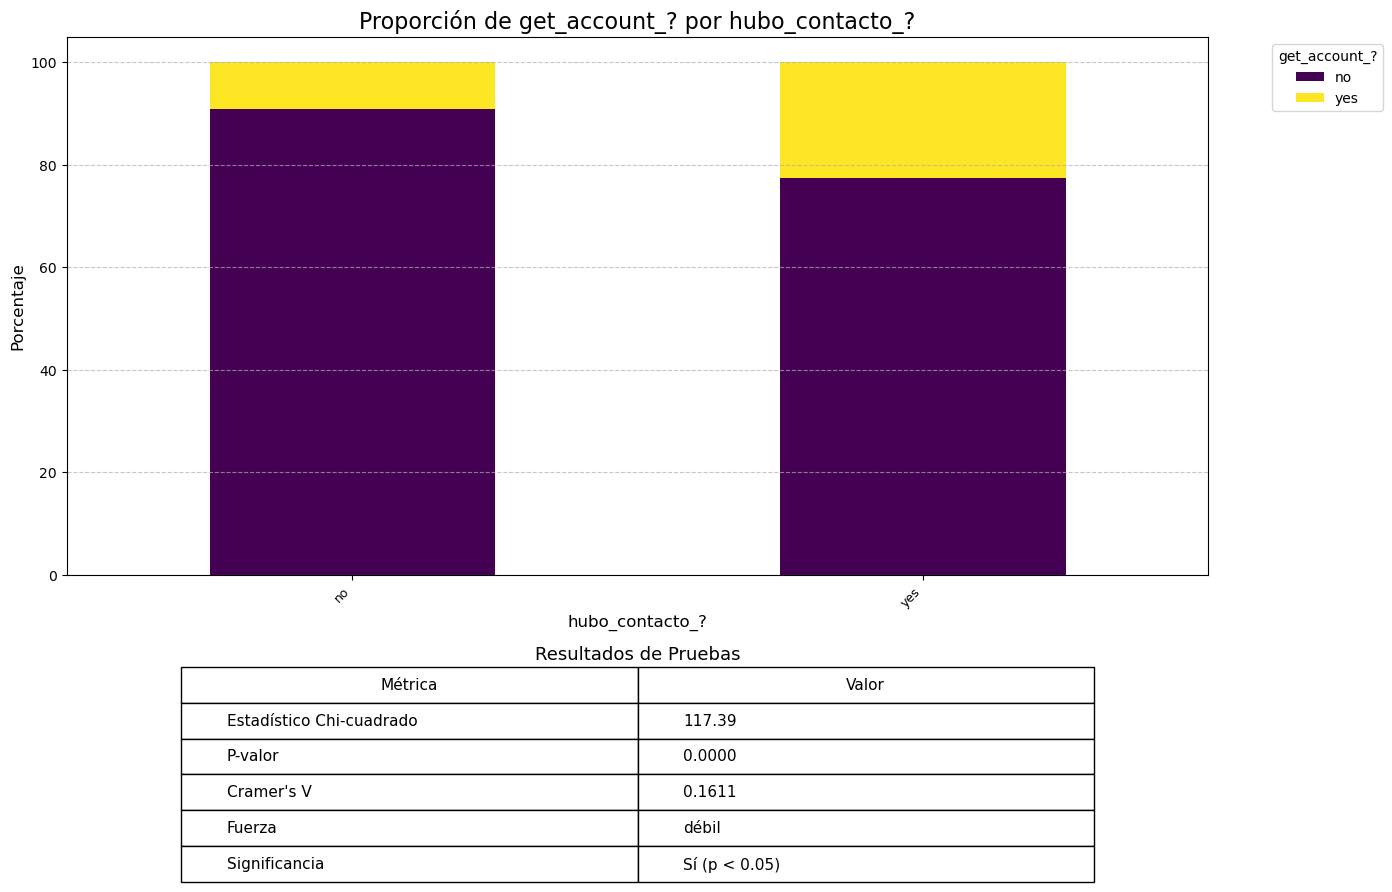

In [6]:
print("\n# 1. Análisis Bivariado Consolidado: Variables Categóricas vs. 'get_account_?' (Tabla Ajustada)")
print("------------------------------------------------------------------------------------------------\n")

for col in categorical_cols:
    # Crear una figura con 2 subplots: uno para el gráfico y otro para la tabla
    # Aumentar ligeramente la altura general de la figura para la tabla más grande
    fig = plt.figure(figsize=(14, 9.5)) # Aumentamos la altura de 8.5 a 9.5
    gs = fig.add_gridspec(2, 1, height_ratios=[5, 2]) # Damos más ratio a la fila de la tabla (de 1 a 2)

    ax_plot = fig.add_subplot(gs[0, 0]) # El gráfico ocupa la primera fila
    ax_table = fig.add_subplot(gs[1, 0]) # La tabla ocupa la segunda fila

    # --- Gráfico de barras apiladas ---
    crosstab_df = pd.crosstab(df_bank_ready[col], df_bank_ready[target_variable], normalize='index') * 100
    crosstab_df.plot(kind='bar', stacked=True, colormap='viridis', ax=ax_plot)

    ax_plot.set_title(f'Proporción de {target_variable} por {col}', fontsize=16)
    ax_plot.set_xlabel(col, fontsize=12)
    ax_plot.set_ylabel('Porcentaje', fontsize=12)
    ax_plot.tick_params(axis='x', rotation=45, labelsize=9)
    for label in ax_plot.get_xticklabels():
        label.set_horizontalalignment('right')

    ax_plot.legend(title=target_variable, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_plot.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Cálculo de estadísticas ---
    contingency_table = pd.crosstab(df_bank_ready[col], df_bank_ready[target_variable])
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1

    cramers_v_value = 0.0
    v_strength_text = "N/A"

    if min_dim > 0:
        cramers_v_value = calculate_cramers_v(chi2, n, min_dim)
        if cramers_v_value < 0.10:
            v_strength_text = "muy débil o inexistente"
        elif cramers_v_value < 0.20:
            v_strength_text = "débil"
        elif cramers_v_value < 0.40:
            v_strength_text = "moderada"
        elif cramers_v_value < 0.60:
            v_strength_text = "fuerte"
        else:
            v_strength_text = "muy fuerte"

    # --- Preparar datos para la tabla ---
    table_data = [
        ["Estadístico Chi-cuadrado", f"{chi2:.2f}"],
        ["P-valor", f"{p_val:.4f}"],
        ["Cramer's V", f"{cramers_v_value:.4f}"],
        ["Fuerza", v_strength_text]
    ]

    # Añadir conclusión de significancia
    if p_val < 0.05:
        table_data.append(["Significancia", "Sí (p < 0.05)"])
    else:
        table_data.append(["Significancia", "No (p >= 0.05)"])

    # --- Crear la tabla ---
    ax_table.axis('off') # Ocultar ejes del subplot de la tabla
    ax_table.set_title("Resultados de Pruebas", fontsize=13, pad=5) # Un poco más grande el título de la tabla

    table = ax_table.table(
        cellText=table_data,
        colLabels=["Métrica", "Valor"],
        loc='center', # Posición de la tabla dentro del subplot
        cellLoc='left', # Alineación del texto en las celdas
        bbox=[0.1, 0.0, 0.8, 1.0] # Ajustar bbox para darle más espacio horizontal y centrarla
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11) # Aumentar el tamaño de la fuente de las celdas
    table.scale(1.1, 1.1) # Escala para hacer las celdas más grandes

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajustar layout
    plt.show()

    # Opcional: imprimir una conclusión concisa en la consola también (si aún la quieres)
    # print(f"--- Resumen para '{col}':")
    # print(f"  P-valor: {p_val:.4f}, Cramer's V: {cramers_v_value:.4f} ({v_strength_text}).")
    # print("-" * 70 + "\n")

###  Conclusiones del Análisis Bivariado de Variables Categóricas vs. 'get_account_?'

A continuación, se presentan las conclusiones para cada variable categórica basada en los gráficos de barras apiladas y los resultados de la prueba de Chi-cuadrado, complementados con el coeficiente V de Cramer para medir la fuerza de la asociación. Un p-valor inferior a 0.05 se considera estadísticamente significativo.

#### **Variable: `job`**
* **Análisis Visual (Barras Apiladas):** Observamos que la proporción de clientes que obtuvieron una cuenta (`yes`) varía entre las diferentes categorías de `job`. Por ejemplo, categorías como 'student' y 'retired' parecen tener una proporción de 'yes' notablemente más alta que otras como 'blue-collar' o 'housemaid'.
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $68.99$
    * P-valor: $0.0000$
    * Cramer's V: $0.1235$
    * Fuerza: Débil
    * Significancia: Sí ($p < 0.05$)
* **Conclusión:** El p-valor ($0.0000$) es estadísticamente significativo, indicando una dependencia entre el tipo de `job` y si el cliente obtiene una cuenta. A pesar de que la fuerza de la asociación (Cramer's V: $0.1235$) es 'Débil', la significancia estadística la convierte en una **variable candidata** para el modelo.

#### **Variable: `marital`**
* **Análisis Visual (Barras Apiladas):** Las proporciones de 'yes' y 'no' son bastante similares entre las categorías 'divorced', 'married' y 'single', aunque 'married' parece tener una proporción ligeramente menor de 'yes'.
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $19.03$
    * P-valor: $0.0001$
    * Cramer's V: $0.0649$
    * Fuerza: Muy débil o inexistente
    * Significancia: Sí ($p < 0.05$)
* **Conclusión:** Aunque el p-valor ($0.0001$) es estadísticamente significativo, el valor de Cramer's V ($0.0649$) sugiere una asociación 'Muy débil o inexistente'. Esto implica que el estado civil (`marital`) tiene una relación estadística con la variable objetivo, pero su impacto en la predicción individual puede ser limitado. Es una **candidata a considerar**, pero con menor peso que otras variables más fuertes.

#### **Variable: `education`**
* **Análisis Visual (Barras Apiladas):** Las proporciones de 'yes' no varían drásticamente entre los niveles de educación, aunque 'tertiary' podría mostrar una ligera inclinación a 'yes' en comparación con 'primary' o 'secondary'.
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $15.24$
    * P-valor: $0.0016$
    * Cramer's V: $0.0581$
    * Fuerza: Muy débil o inexistente
    * Significancia: Sí ($p < 0.05$)
* **Conclusión:** Similar a `marital`, el p-valor ($0.0016$) es significativo, pero la fuerza de la asociación ($0.0581$) es 'Muy débil o inexistente'. `education` es una **candidata con baja influencia predictiva bivariada**, pero podría interactuar con otras variables en el modelo multivariado.

#### **Variable: `default`**
* **Análisis Visual (Barras Apiladas):** Las proporciones de 'yes' y 'no' son casi idénticas entre los clientes con y sin historial de `default` (impago). Visualmente, no hay diferencia aparente.
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $0.00$
    * P-valor: $1.0000$
    * Cramer's V: $0.0000$
    * Fuerza: Muy débil o inexistente
    * Significancia: No ($p >= 0.05$)
* **Conclusión:** El p-valor ($1.0000$) y el Cramer's V ($0.0000$) indican que **no hay ninguna relación estadísticamente significativa** entre `default` y `get_account_?`. Esta variable **no es una buena predictora** y debería ser excluida del modelo.

#### **Variable: `housing`**
* **Análisis Visual (Barras Apiladas):** Se observa una ligera diferencia. Los clientes sin préstamo de vivienda (`no`) tienen una proporción de 'yes' un poco más alta que aquellos con un préstamo de vivienda (`yes`).
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $48.88$
    * P-valor: $0.0000$
    * Cramer's V: $0.1040$
    * Fuerza: Débil
    * Significancia: Sí ($p < 0.05$)
* **Conclusión:** Con un p-valor de $0.0000$, existe una **diferencia estadísticamente significativa** en la proporción de `get_account_?` entre los grupos de `housing`. Aunque la fuerza es 'Débil' ($0.1040$), la significancia la hace una **variable candidata** para el modelo.

#### **Variable: `loan`**
* **Análisis Visual (Barras Apiladas):** Similar a `housing`, se percibe una pequeña diferencia, con los clientes sin préstamo personal (`no`) mostrando una fracción ligeramente mayor de 'yes'.
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $21.87$
    * P-valor: $0.0000$
    * Cramer's V: $0.0696$
    * Fuerza: Muy débil o inexistente
    * Significancia: Sí ($p < 0.05$)
* **Conclusión:** El p-valor ($0.0000$) es significativo, pero el Cramer's V ($0.0696$) es 'Muy débil o inexistente'. `loan` es una **candidata a considerar**, pero su poder predictivo bivariado es bajo.

#### **Variable: `contact`**
* **Análisis Visual (Barras Apiladas):** Hay una diferencia notable en las proporciones de 'yes'. Los contactos 'unknown' (desconocidos) y 'telephone' (teléfono) tienen una proporción mucho menor de 'yes' en comparación con 'cellular' (celular).
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $87.87$
    * P-valor: $0.0000$
    * Cramer's V: $0.1394$
    * Fuerza: Débil
    * Significancia: Sí ($p < 0.05$)
* **Conclusión:** El p-valor ($0.0000$) es altamente significativo, indicando una **fuerte dependencia estadística** entre el tipo de `contact` y `get_account_?`. A pesar de que la fuerza (Cramer's V: $0.1394$) es 'Débil', la significancia es crucial. `contact` es una **variable candidata importante** para el modelo.

#### **Variable: `day`**
* **Análisis Visual (Barras Apiladas):** La proporción de 'yes' fluctúa considerablemente a lo largo de los días del mes, sin un patrón claro y consistente. Aunque algunas barras individuales muestran diferencias, la variabilidad general es alta.
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $91.03$
    * P-valor: $0.0000$
    * Cramer's V: $0.1419$
    * Fuerza: Débil
    * Significancia: Sí ($p < 0.05$)
* **Conclusión:** El p-valor ($0.0000$) es estadísticamente significativo, y el Cramer's V ($0.1419$) es 'Débil'. Esto sugiere que el `day` de contacto tiene una relación con `get_account_?`. Aunque la visualización por cada día es ruidosa, la significancia global indica que es una **variable candidata**. Sin embargo, su granularidad podría requerir una agrupación posterior (ej., por semana o quincena) si la relación no es estable por día individual.

#### **Variable: `month`**
* **Análisis Visual (Barras Apiladas):** Hay variaciones muy claras en la proporción de 'yes' a lo largo de los meses. Algunos meses (ej., marzo, septiembre, octubre, diciembre, agosto) muestran proporciones de 'yes' considerablemente más altas, mientras que otros son mucho más bajas.
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $250.50$
    * P-valor: $0.0000$
    * Cramer's V: $0.2354$
    * Fuerza: Moderada
    * Significancia: Sí ($p < 0.05$)
* **Conclusión:** Con un p-valor de $0.0000$ y un Cramer's V de $0.2354$ ('Moderada'), `month` es una **variable predictora fuerte y muy significativa**. La época del año en que se realiza el contacto es un factor importante para determinar si un cliente obtiene una cuenta.

#### **Variable: `poutcome`**
* **Análisis Visual (Barras Apiladas):** Existe una diferencia muy marcada. La categoría `success` (éxito en campaña previa) tiene una proporción de 'yes' significativamente más alta (casi el 60%) en comparación con 'failure', 'other' o 'unknown', que tienen proporciones mucho más bajas (menos del 20%).
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $386.88$
    * P-valor: $0.0000$
    * Cramer's V: $0.2925$
    * Fuerza: Moderada
    * Significancia: Sí ($p < 0.05$)
* **Conclusión:** El p-valor ($0.0000$) es altamente significativo y el Cramer's V ($0.2925$) es 'Moderada', lo que la convierte en una **variable predictora muy fuerte**. El resultado de la campaña anterior (`poutcome`) es un factor determinante para la obtención de una cuenta.

#### **Variable: `hubo_contacto_?`**
* **Análisis Visual (Barras Apiladas):** La proporción de clientes que obtuvieron una cuenta (`yes`) es notablemente más alta para aquellos donde `hubo_contacto_?` es 'yes' (se realizó un contacto), en comparación con el grupo 'no' (sin contacto o desconocido).
* **Resultados de Pruebas:**
    * Estadístico Chi-cuadrado: $117.39$
    * P-valor: $0.0000$
    * Cramer's V: $0.1611$
    * Fuerza: Débil
    * Significancia: Sí ($p < 0.05$)
* **Conclusión:** El p-valor ($0.0000$) es altamente significativo, indicando una **fuerte dependencia estadística** entre `hubo_contacto_?` y `get_account_?`. A pesar de que la fuerza (Cramer's V: $0.1611$) es 'Débil', la alta significancia la hace una **variable candidata importante** para el modelo, sugiriendo que la existencia de un contacto previo influye en la probabilidad de obtener una cuenta.

---

**Resumen General de Variables Categóricas para el Modelo Logístico:**

Las variables categóricas `job`, `marital`, `education`, `housing`, `loan`, `contact`, `day`, `month`, `poutcome`, y `hubo_contacto_?` han mostrado una asociación estadísticamente significativa con la variable objetivo `get_account_?` (p-valor < 0.05), aunque la fuerza de algunas de estas asociaciones es 'Débil' o 'Muy débil'. La única variable categórica que **no parece ser una buena predictora** en el análisis bivariado y que, por tanto, podría ser excluida es `default` (p-valor >= 0.05).

Las variables `month`, `poutcome`, `hubo_contacto_?`, `job`, `contact`, `housing`, `day`, `marital`, y `education` son **candidatas para ser incluidas** en el modelo de regresión logística, con `month` y `poutcome` destacando por su fuerza de asociación moderada.

## Analisis bivariado para variables numericas 

Ahora veamos cual de las variables numericas podrian ser mejor para nuestro modelo para ello realizaremos una prueba Mann-Whitney U


# 2. Análisis Bivariado: Variables Numéricas (Transformadas) vs. 'get_account_?' (Layout Optimizado - Tabla Debajo)
------------------------------------------------------------------------------------------------------------------



C:\Users\delhy.py\AppData\Local\Temp\ipykernel_3136\825383941.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=df_bank_ready, palette='coolwarm', ax=ax_plot)


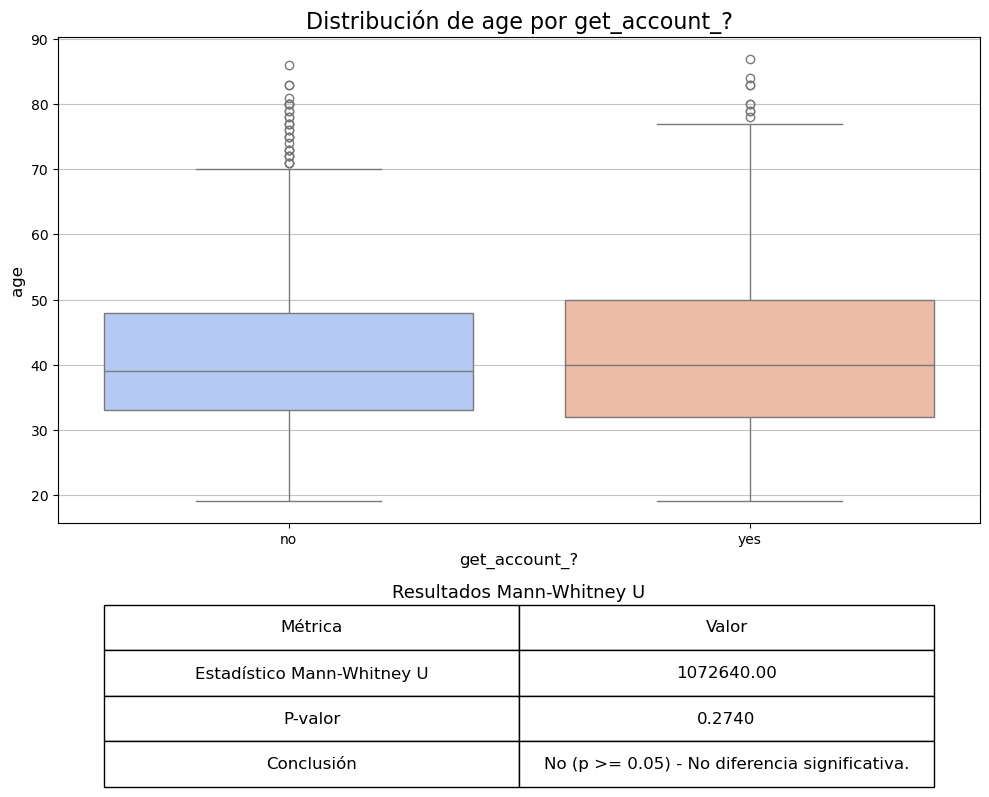

C:\Users\delhy.py\AppData\Local\Temp\ipykernel_3136\825383941.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=df_bank_ready, palette='coolwarm', ax=ax_plot)


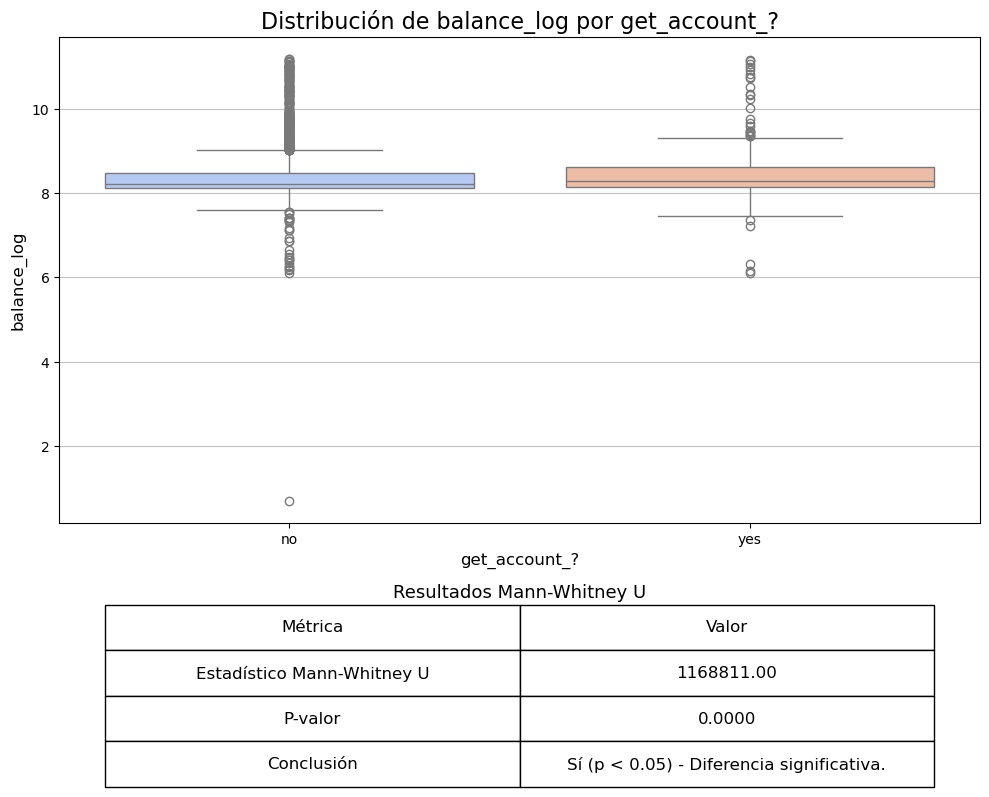

C:\Users\delhy.py\AppData\Local\Temp\ipykernel_3136\825383941.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=df_bank_ready, palette='coolwarm', ax=ax_plot)


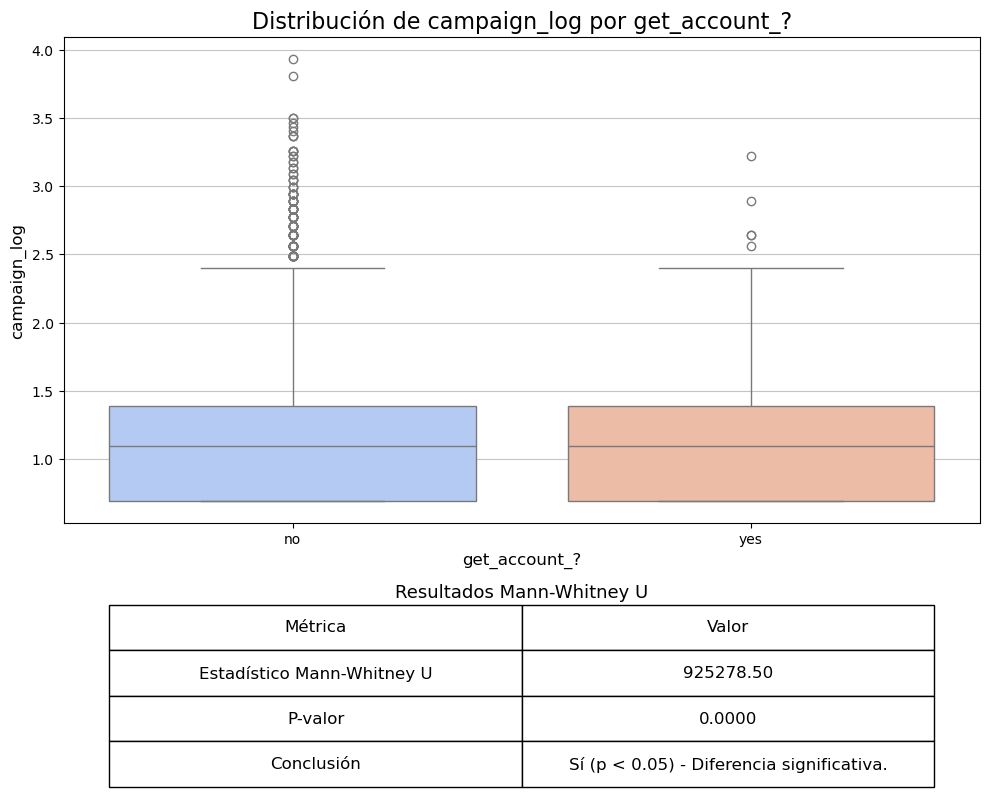

C:\Users\delhy.py\AppData\Local\Temp\ipykernel_3136\825383941.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=df_bank_ready, palette='coolwarm', ax=ax_plot)


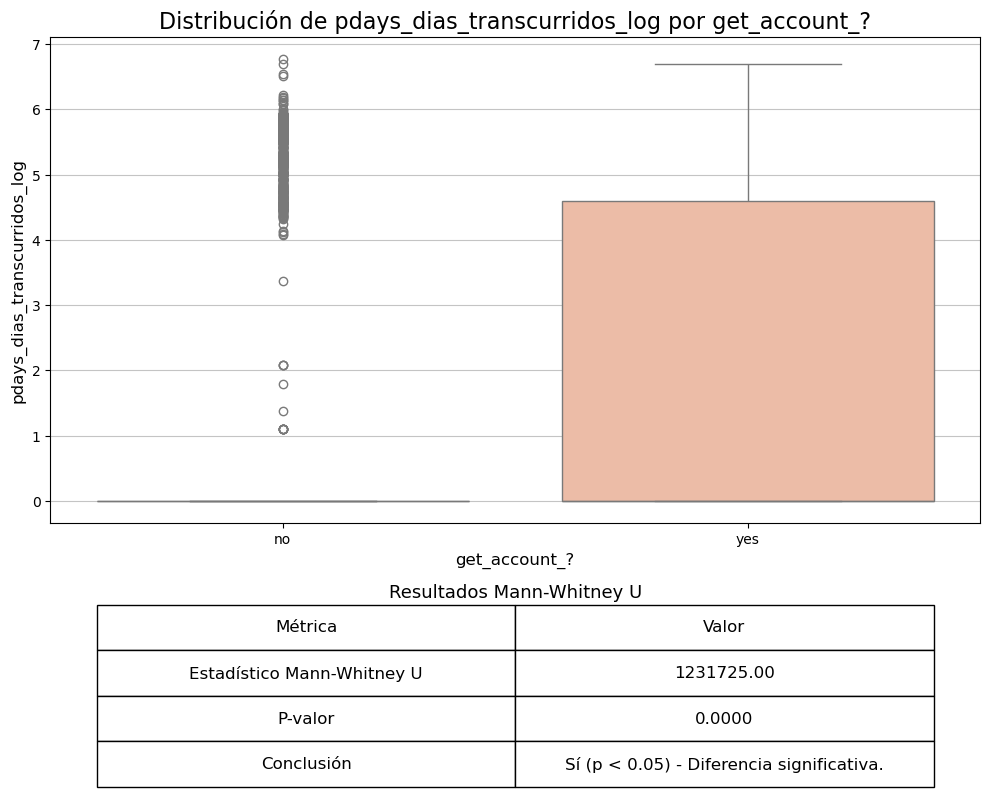

C:\Users\delhy.py\AppData\Local\Temp\ipykernel_3136\825383941.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_variable, y=col, data=df_bank_ready, palette='coolwarm', ax=ax_plot)


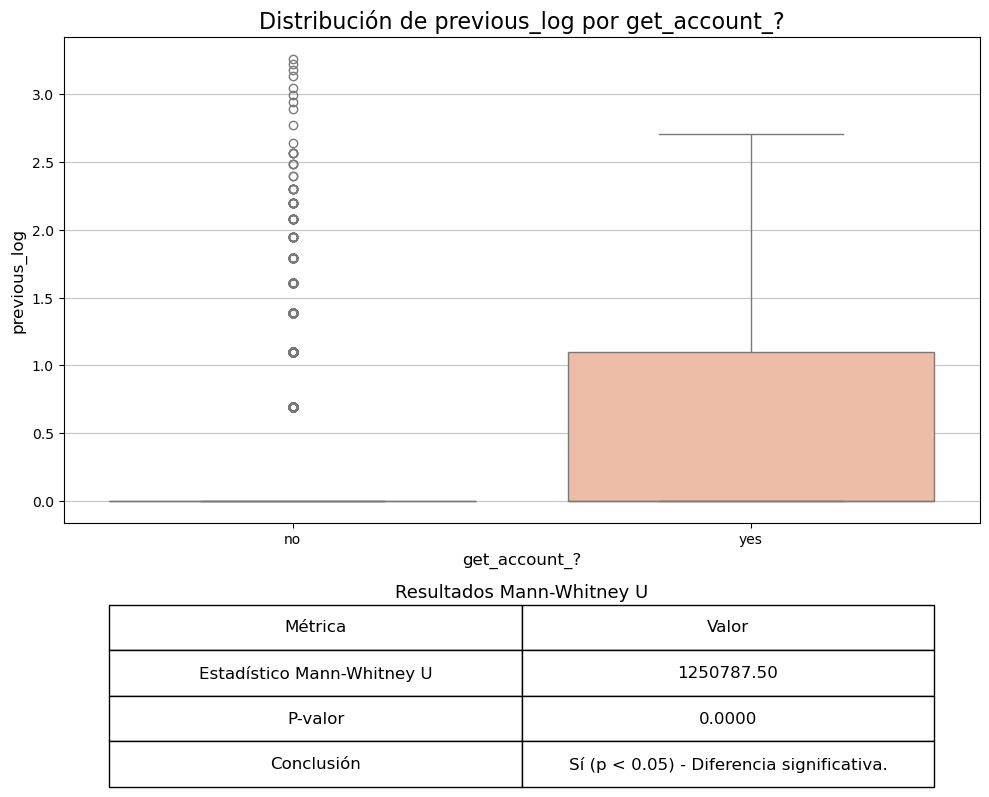

In [7]:
print("\n# 2. Análisis Bivariado: Variables Numéricas (Transformadas) vs. 'get_account_?' (Layout Optimizado - Tabla Debajo)")
print("------------------------------------------------------------------------------------------------------------------\n")

for col in numerical_cols:
    # Crear una figura con 2 subplots: uno para el boxplot (arriba) y otro para la tabla (abajo)
    # Aumentamos la altura general para acomodar boxplot y tabla verticalmente
    fig = plt.figure(figsize=(10, 8.5)) # Ancho razonable, altura suficiente para ambos
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1.5]) # Boxplot 4x, tabla 1.5x

    ax_plot = fig.add_subplot(gs[0, 0]) # Boxplot en la primera fila
    ax_table = fig.add_subplot(gs[1, 0]) # Tabla en la segunda fila

    # --- Boxplot ---
    sns.boxplot(x=target_variable, y=col, data=df_bank_ready, palette='coolwarm', ax=ax_plot)
    ax_plot.set_title(f'Distribución de {col} por {target_variable}', fontsize=16)
    ax_plot.set_xlabel(target_variable, fontsize=12)
    ax_plot.set_ylabel(col, fontsize=12)
    ax_plot.grid(axis='y', alpha=0.75)

    # --- Cálculo de la prueba Mann-Whitney U ---
    group_yes = df_bank_ready[df_bank_ready[target_variable] == 'yes'][col]
    group_no = df_bank_ready[df_bank_ready[target_variable] == 'no'][col]

    group_yes = group_yes.dropna()
    group_no = group_no.dropna()

    stat = np.nan
    p_val = np.nan
    conclusion_text = "No hay suficientes datos para la prueba."

    if not group_yes.empty and not group_no.empty:
        if len(group_yes) > 1 and len(group_no) > 1:
            stat, p_val = mannwhitneyu(group_yes, group_no, alternative='two-sided')
            if p_val < 0.05:
                conclusion_text = "Sí (p < 0.05) - Diferencia significativa."
            else:
                conclusion_text = "No (p >= 0.05) - No diferencia significativa."
        else:
            conclusion_text = "Grupos con muy pocos datos para la prueba."
    
    # --- Preparar datos para la tabla ---
    table_data = [
        ["Métrica", "Valor"], # Encabezados
        ["Estadístico Mann-Whitney U", f"{stat:.2f}" if not np.isnan(stat) else "N/A"],
        ["P-valor", f"{p_val:.4f}" if not np.isnan(p_val) else "N/A"],
        ["Conclusión", conclusion_text]
    ]

    # --- Crear la tabla en el subplot de abajo ---
    ax_table.axis('off') # Ocultar ejes del subplot de la tabla
    ax_table.set_title("Resultados Mann-Whitney U", fontsize=13, pad=5) # Título para la tabla

    table = ax_table.table(
        cellText=table_data[1:], # Excluir la fila de encabezados para cellText
        colLabels=table_data[0], # Usar la primera fila como colLabels
        loc='center',
        cellLoc='center', # Centrar el texto en las celdas
        # bbox ajustado para centrar y que ocupe bien el espacio asignado
        bbox=[0.05, 0.0, 0.9, 1.0] # [x, y, width, height]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12) # Tamaño de fuente de las celdas de la tabla
    table.scale(1.0, 1.5) # Escala para hacer las filas más altas y "cuadradas"

    # Ajustar el layout general para que los subplots no se superpongan
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajustar rect para el título general
    plt.show()

###  Conclusiones del Análisis Bivariado de Variables Numéricas vs. 'get_account_?'

A continuación, se presentan las conclusiones para cada variable numérica (`age`, `balance_log`, `campaign_log`, `pdays_dias_transcurridos_log`, `previous_log`) basada en los diagramas de caja y los resultados de la prueba no paramétrica de Mann-Whitney U. Un p-valor inferior a 0.05 se considera estadísticamente significativo, indicando una diferencia entre las medianas de los grupos 'yes' y 'no' de 'get_account_?'.

#### **Variable: `age`**
* **Análisis Visual (Box Plot):** La distribución de `age` para los clientes que obtuvieron una cuenta (`yes`) y los que no (`no`) muestra cierta superposición. Las medianas (líneas dentro de las cajas) están relativamente cerca. Visualmente, no se observa una separación drástica entre los grupos.
* **Resultados Mann-Whitney U:**
    * Estadístico Mann-Whitney U: $1072640.00$
    * P-valor: $0.2740$
* **Conclusión:** Dado que el p-valor ($0.2740$) es mayor que $0.05$, no hay una diferencia estadísticamente significativa en las medianas de la edad entre los clientes que obtuvieron una cuenta y los que no. Por lo tanto, `age` **no parece ser un predictor fuerte** para el modelo de regresión logística basado en este análisis bivariado.

#### **Variable: `balance_log`**
* **Análisis Visual (Box Plot):** Se observa una clara diferencia en la distribución de `balance_log` entre los grupos 'no' y 'yes'. La mediana y el rango intercuartílico de `balance_log` son visiblemente más altos para el grupo 'yes' (clientes que obtuvieron una cuenta) en comparación con el grupo 'no'.
* **Resultados Mann-Whitney U:**
    * Estadístico Mann-Whitney U: $1168811.00$
    * P-valor: $0.0000$
* **Conclusión:** Con un p-valor de $0.0000$ (mucho menor que $0.05$), existe una **diferencia estadísticamente significativa** en las medianas de `balance_log` entre los dos grupos. Esto sugiere que `balance_log` es una **variable predictora muy importante** para determinar si un cliente obtiene una cuenta o no.

#### **Variable: `campaign_log`**
* **Análisis Visual (Box Plot):** La distribución de `campaign_log` muestra que el grupo 'no' tiende a tener valores ligeramente más altos que el grupo 'yes', aunque la superposición es considerable. Las medianas de ambos grupos son relativamente cercanas.
* **Resultados Mann-Whitney U:**
    * Estadístico Mann-Whitney U: $925278.50$
    * P-valor: $0.0000$
* **Conclusión:** A pesar de la superposición visual, el p-valor ($0.0000$) es significativamente menor que $0.05$, lo que indica una **diferencia estadísticamente significativa** en las medianas de `campaign_log` entre los grupos. Esto significa que `campaign_log` es una **variable predictora relevante**, sugiriendo que el número de contactos durante la campaña (transformado logarítmicamente) tiene un impacto en la decisión de obtener una cuenta.

#### **Variable: `pdays_dias_transcurridos_log`**
* **Análisis Visual (Box Plot):** La gráfica muestra una marcada diferencia. El grupo 'no' tiene una gran concentración de valores cercanos a cero (lo que indica que no hubo contacto previo o fue hace mucho tiempo, resultando en un valor bajo o cero después del logaritmo), mientras que el grupo 'yes' exhibe valores de `pdays_dias_transcurridos_log` notablemente más altos, con una distribución más dispersa. Esto sugiere que un contacto reciente con la campaña (menos días transcurridos) está asociado con la obtención de una cuenta.
* **Resultados Mann-Whitney U:**
    * Estadístico Mann-Whitney U: $1231725.00$
    * P-valor: $0.0000$
* **Conclusión:** Con un p-valor de $0.0000$, hay una **diferencia estadísticamente muy significativa** en las medianas de `pdays_dias_transcurridos_log` entre los grupos. Esta variable es, por lo tanto, una **variable predictora muy fuerte** para el modelo.

#### **Variable: `previous_log`**
* **Análisis Visual (Box Plot):** Se observa una clara distinción entre los grupos. El grupo 'no' tiene la mayoría de sus valores de `previous_log` concentrados en cero, lo que implica pocas o ninguna campaña previas. En contraste, el grupo 'yes' muestra valores de `previous_log` considerablemente más altos, con una distribución que indica que los clientes con más contactos previos (exitosos) tienden a obtener una cuenta.
* **Resultados Mann-Whitney U:**
    * Estadístico Mann-Whitney U: $1250787.50$
    * P-valor: $0.0000$
* **Conclusión:** Con un p-valor de $0.0000$, se confirma una **diferencia estadísticamente muy significativa** en las medianas de `previous_log` entre los grupos. Esto convierte a `previous_log` en una **variable predictora muy importante** para el modelo logístico.

---

**Resumen General de Variables Numéricas para el Modelo Logístico:**

Basado en el análisis bivariado, las variables numéricas `balance_log`, `campaign_log`, `pdays_dias_transcurridos_log`, y `previous_log` han mostrado una diferencia estadísticamente significativa entre los clientes que abrieron una cuenta y los que no. Por lo tanto, estas cuatro variables son **candidatas fuertes para ser incluidas** en el modelo de regresión logística. La variable `age` no mostró una diferencia significativa en este análisis bivariado.

Y ahora ahora que sabes cuales variables numericas y categoricas son las mas indicadas para la cotruccion de nuestro modelo logistico es hora de pasar a la construccion del mismo

Voy a guardar un csv nuevamente ya que anteriormente arreglamos la columna hubo_contacto_?

In [8]:
df_bank_ready.to_csv("bank_ready_for_model.csv", index=False)